<h1 style="font-size: 80px; color: blue"> 
Olivia Finder - Usage
</h1>


This notebook consists in the use of the **Olivia** library with the different data obtained through **Olivia Finder**

-    How to generate a data set using Olivia-Finder
-    How we can generate an Olivia model from these data.
-    How can we use the Olivia model

# **0 - Previous requirements**

## Setup venv and install requirements

In [49]:
# Olivia requirements
%pip install -r ../olivia/requirements.txt

  Using cached intbitset-2.4.0.tar.gz (151 kB)
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.18.5-cp38-cp38-manylinux1_x86_64.whl (20.6 MB)
  Using cached networkx-2.4-py3-none-any.whl (1.6 MB)
  Using cached pandas-1.1.5-cp38-cp38-manylinux1_x86_64.whl (9.3 MB)
  Using cached matplotlib-3.2.2-cp38-cp38-manylinux1_x86_64.whl (12.4 MB)
Using legacy 'setup.py install' for intbitset, since package 'wheel' is not installed.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
  Running setup.py install for intbitset ... done
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.2
    Uninstalling pandas-2.0.2:
      Successfully uninstalled pandas-2.0.2
  Attempting uninstall: matplotlib
    Found existi

In [29]:
# Olivia Finder requirements
%pip install -r requirements.txt

You should consider upgrading via the '/home/daniel.alonso/.pyenv/versions/3.8.16/envs/python_3.8/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


If you use a virtual environment, it is necessary to configure it as selected in the Jupyter kernel


## Setup library path

Make sure to run this cell to have the **olivia** and **olivia-finder** library at PATH

In [30]:
# Append the path to the olivia_finder package
import sys
sys.path.append('../../olivia/')
sys.path.append('../../olivia_finder/')

## Setup configuration

It is necessary to initialize the configuration, the most comfortable and global way to do so is through an environment variable

In [31]:
# Add the environment variable OLIVIA_FINDER_CONFIG_FILE_PATH

import os
os.environ['OLIVIA_FINDER_CONFIG_FILE_PATH'] = "../../olivia_finder/config.ini"

# **1 - Build the dataset**

In this section we will use Olivia Finder to build the dataset of the network that we want to analyze

In [32]:
from olivia_finder.package_manager import PackageManager

## Using data from persistence

### Olivia finder persistence objects

We can use persistence objects generated with Olivia-Finder previously and from them generate a Networkx graph with which to feed Olivia

In [33]:
# Load bioconductor olivia-finder persistence package manager object
bioconductor_pm_loaded = PackageManager.load_from_persistence("aux_data/bioconductor_scraper.olvpm")

# Get the networkx graph object
bioconductor_G_loaded = bioconductor_pm_loaded.get_network_graph()
print(f'Nodes: {len(bioconductor_G_loaded.nodes)}')
print(f'Edges: {len(bioconductor_G_loaded.edges)}')

Nodes: 3509
Edges: 28320


### Csv files

Load the bioconductor network using a CSV file on a package manager object

In [34]:
bioconductor_pm_csv =  PackageManager.load_from_csv(
    "aux_data/bioconductor_adjlist_scraping.csv", 
    dependent_field='name', 
    dependency_field='dependency',
)
bioconductor_G_csv = bioconductor_pm_csv.get_network_graph()
print(f'Nodes: {len(bioconductor_G_csv.nodes)}')
print(f'Edges: {len(bioconductor_G_csv.edges)}')

Nodes: 3509
Edges: 28320


In [35]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_degree_distribution(G, title):
    '''
    Plot the degree distribution of a networkx graph
    '''

    # Nodes' degree vector
    degree=[x[1] for x in G.degree()]
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Linear plot
    axs[0].plot(degree, color='r', marker='o', linestyle='None')
    axs[0].set_title(title)
    axs[0].set_xlabel('Degree')
    axs[0].set_ylabel('Number of nodes')
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')

    
    # Plot histogram with log scale
    axs[1].hist(degree, bins=100, color='r')
    axs[1].set_title(title)
    axs[1].set_xlabel('Degree')
    axs[1].set_ylabel('Number of nodes')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    
    plt.show()

def draw_networkx_graph(G, layout='circular', size=(20,20), labels=True, override_node_size=0):
    '''
    Draw a networkx graph
    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
    }
    plt.figure(figsize=size)
    pos = layouts[layout](G)
    if override_node_size == 0:
        node_size = [G.in_degree(node) *80 for node in G]
    else:
        node_size = [override_node_size for node in G]

    node_color = [G.in_degree(node) for node in G]
    node_opacity = 0.8
    edge_color = 'black'
    edge_opacity = 0.3

    width = 1

    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_size,
        node_color=node_color,
        alpha=node_opacity
    )

    nx.draw_networkx_edges(
        G,
        pos,
        edge_color=edge_color,
        alpha=edge_opacity,
        width=width
    )
    
    # Agregar etiquetas personalizadas
    if labels:
        nx.draw_networkx_labels(G, pos, font_size=8)

    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()


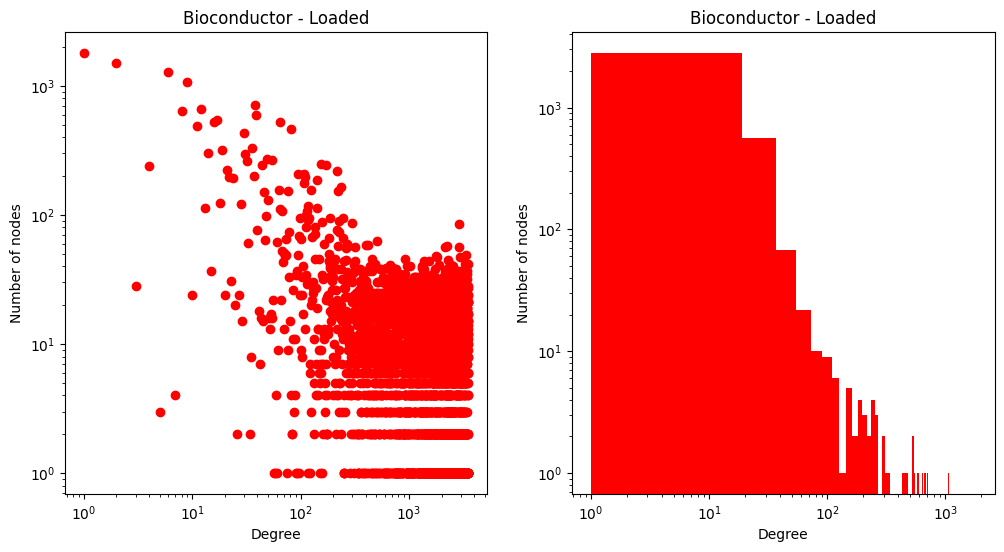

In [36]:
plot_degree_distribution(bioconductor_G_loaded, "Bioconductor - Loaded")

Nodes: 441
Edges: 307


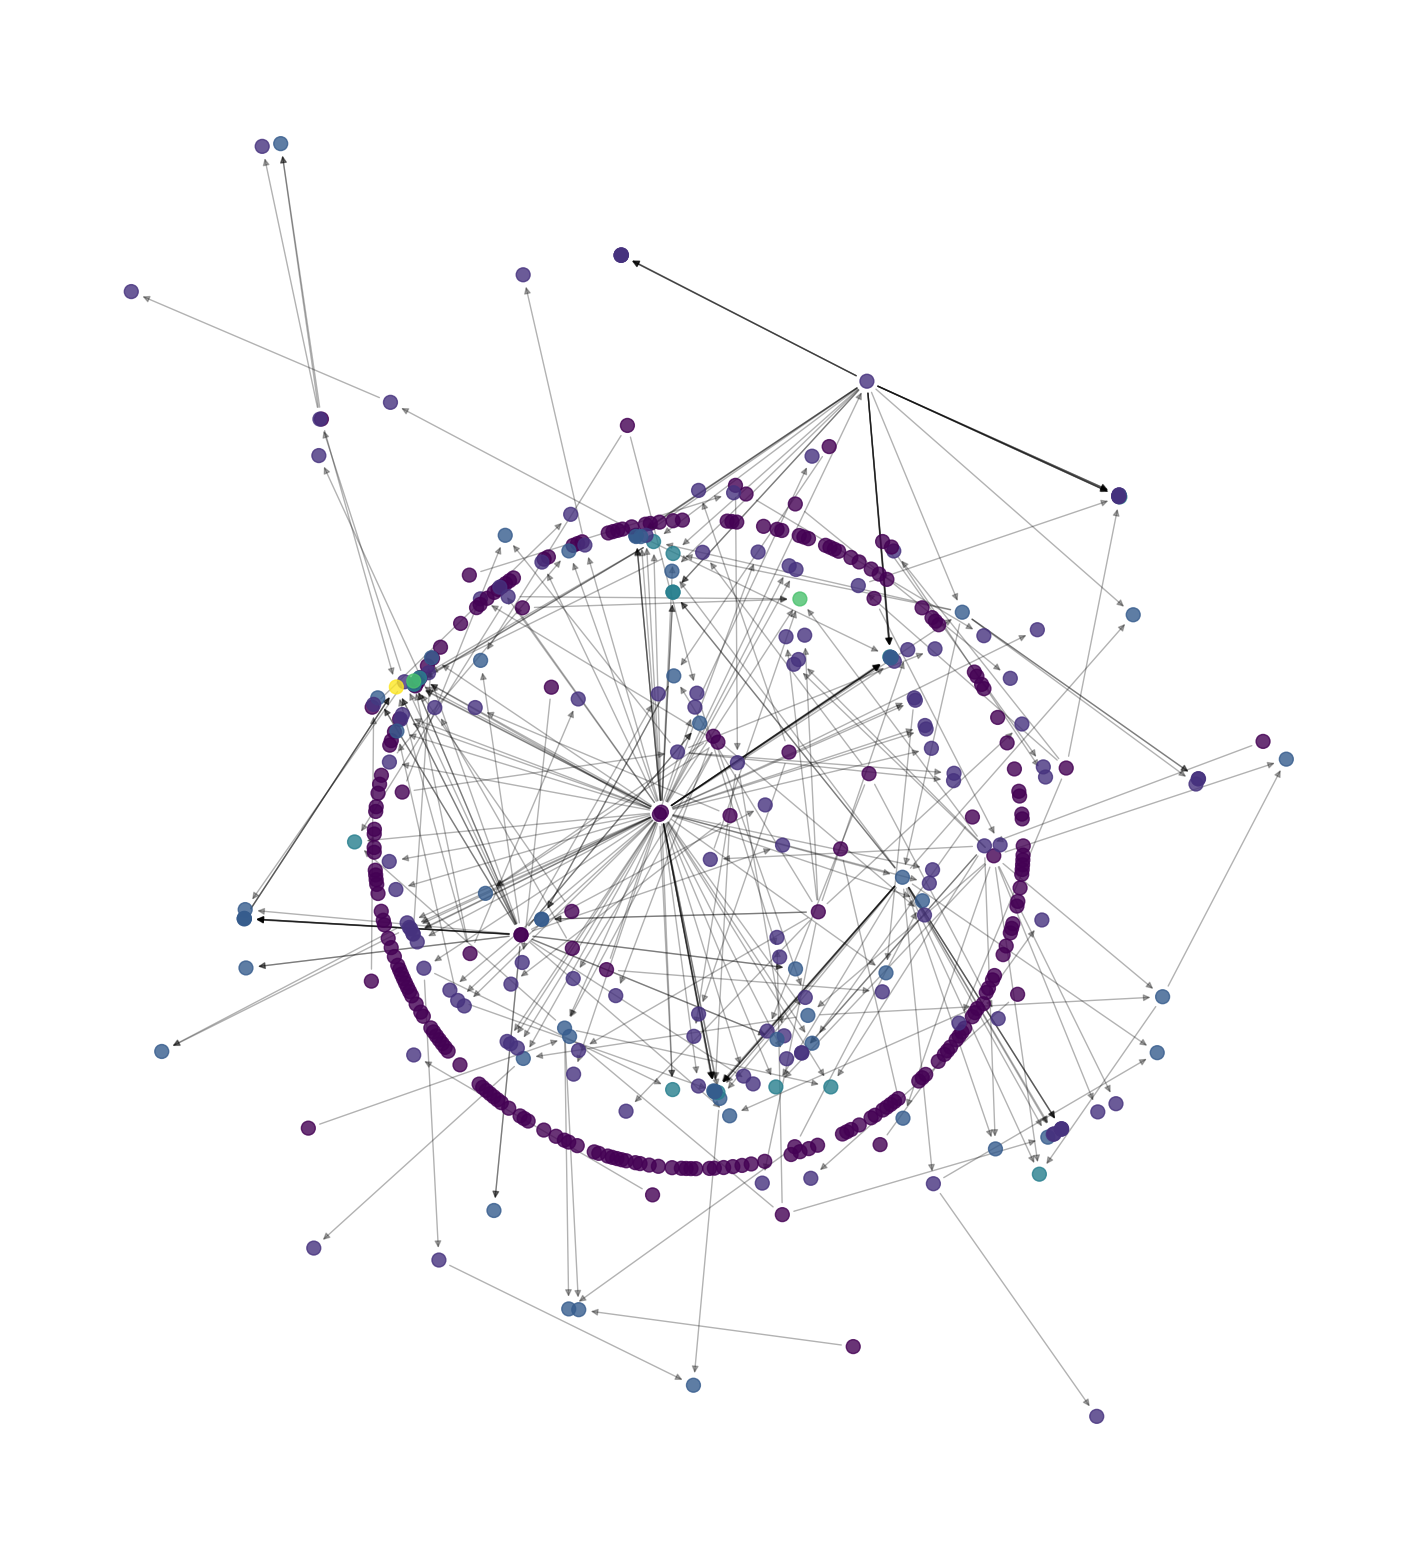

In [37]:
# Drop nodes with in_degree < 20
bioconductor_G_csv_filtered = bioconductor_G_csv.copy()
for node in bioconductor_G_csv.nodes:
    if bioconductor_G_csv.in_degree(node) < 20:
        bioconductor_G_csv_filtered.remove_node(node)

print(f'Nodes: {len(bioconductor_G_csv_filtered.nodes)}')
print(f'Edges: {len(bioconductor_G_csv_filtered.edges)}')

# Draw the graph
draw_networkx_graph(bioconductor_G_csv_filtered, layout='kamada_kawai', size=(20,20), labels=False, override_node_size=100)


## Build custom network

**Instantance the Package Manager object according to our needs**

#### Scraping data

Build the network for the "twitter" package

In [38]:
import gc
from olivia_finder.data_source.repository_scrapers.npm import NpmScraper

npm_pm = PackageManager(
    data_sources=[NpmScraper()]
)
twitter_G  = npm_pm.get_transitive_network_graph(
    package_name="twitter", 
    deep_level=3, 
    generate=True
)
del npm_pm
gc.collect()
print(f'Nodes: {len(twitter_G.nodes)}')
print(f'Edges: {len(twitter_G.edges)}')

Nodes: 1179
Edges: 2656


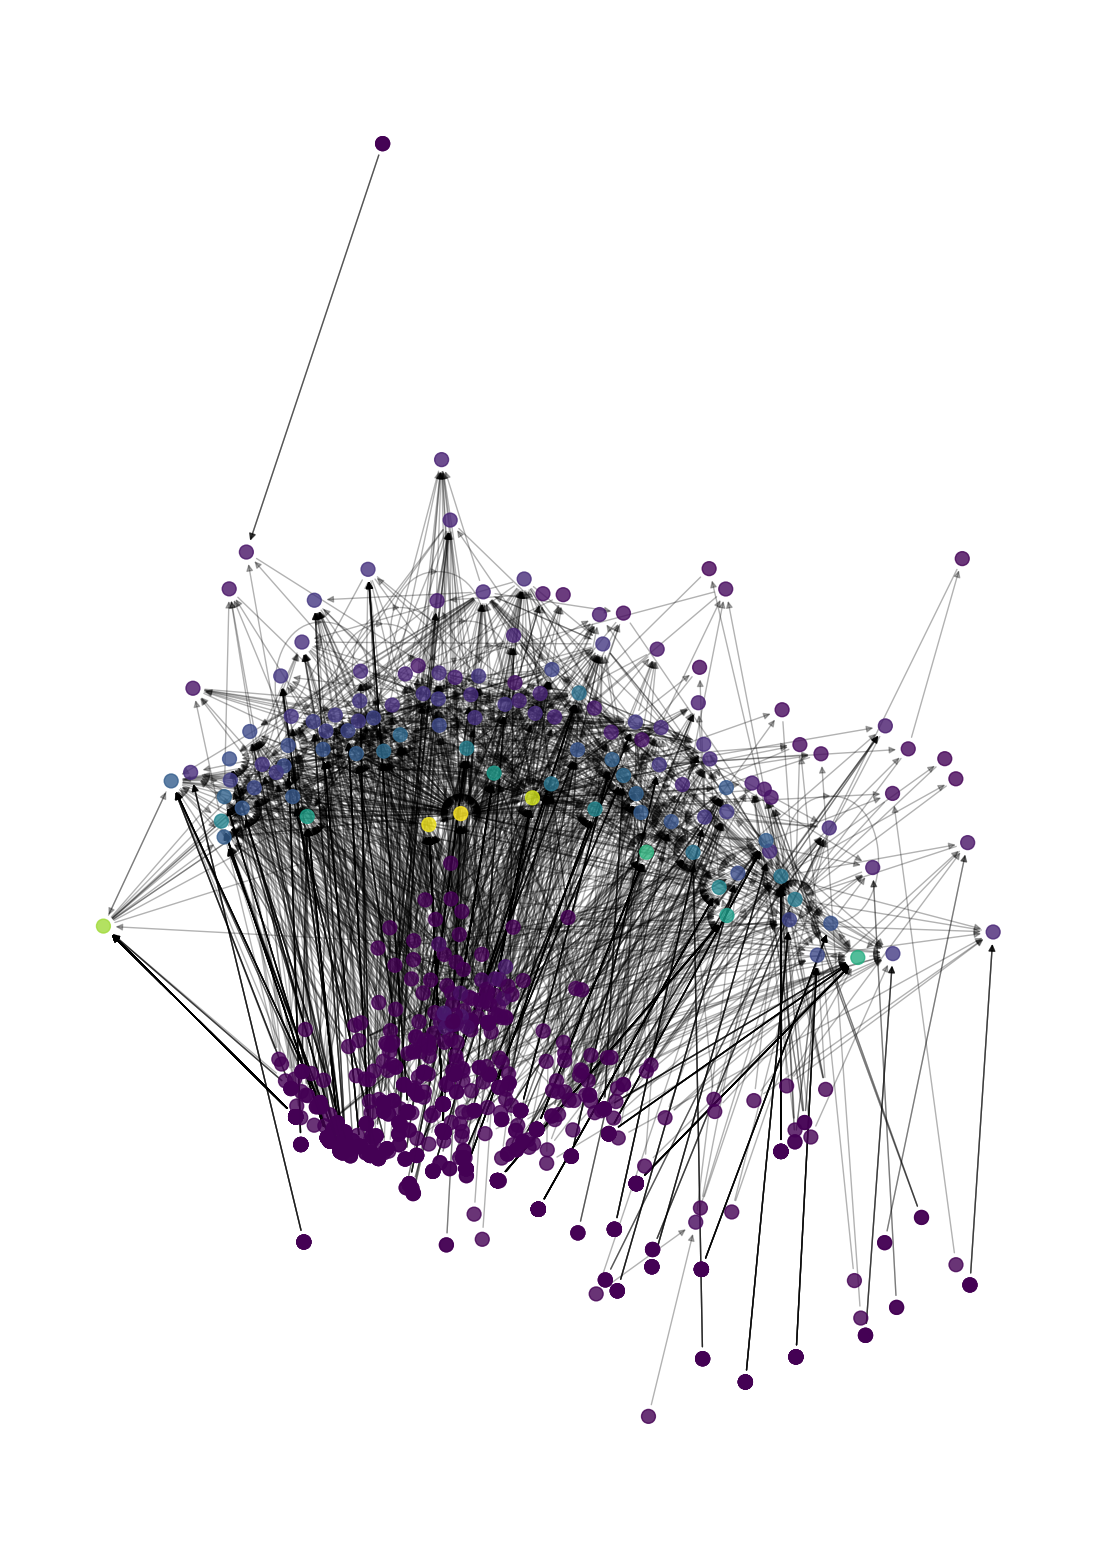

In [39]:
# # Draw the graph using the kamada_kawai layout
draw_networkx_graph(twitter_G, layout='kamada_kawai', size=(20,20), labels=False, override_node_size=100)

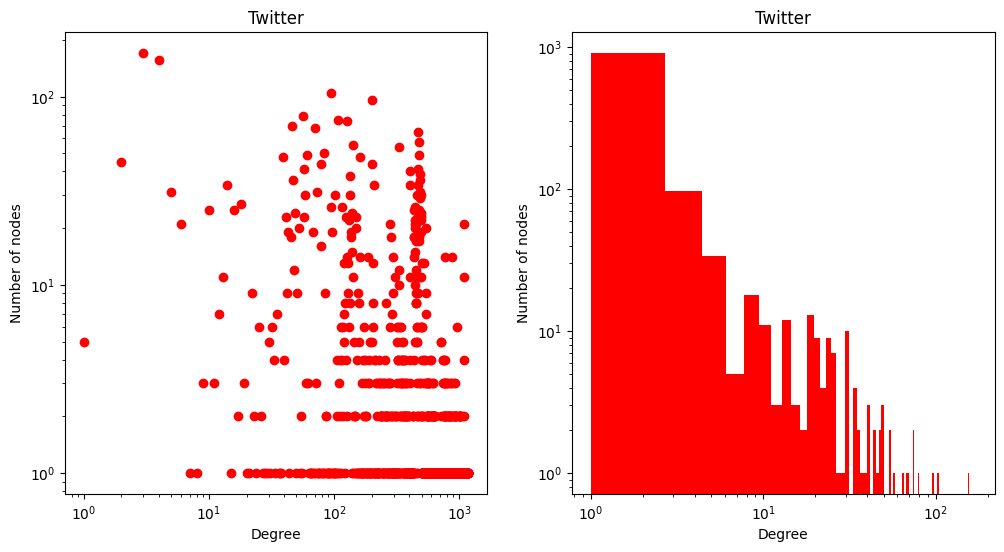

In [40]:
plot_degree_distribution(twitter_G, "Twitter")

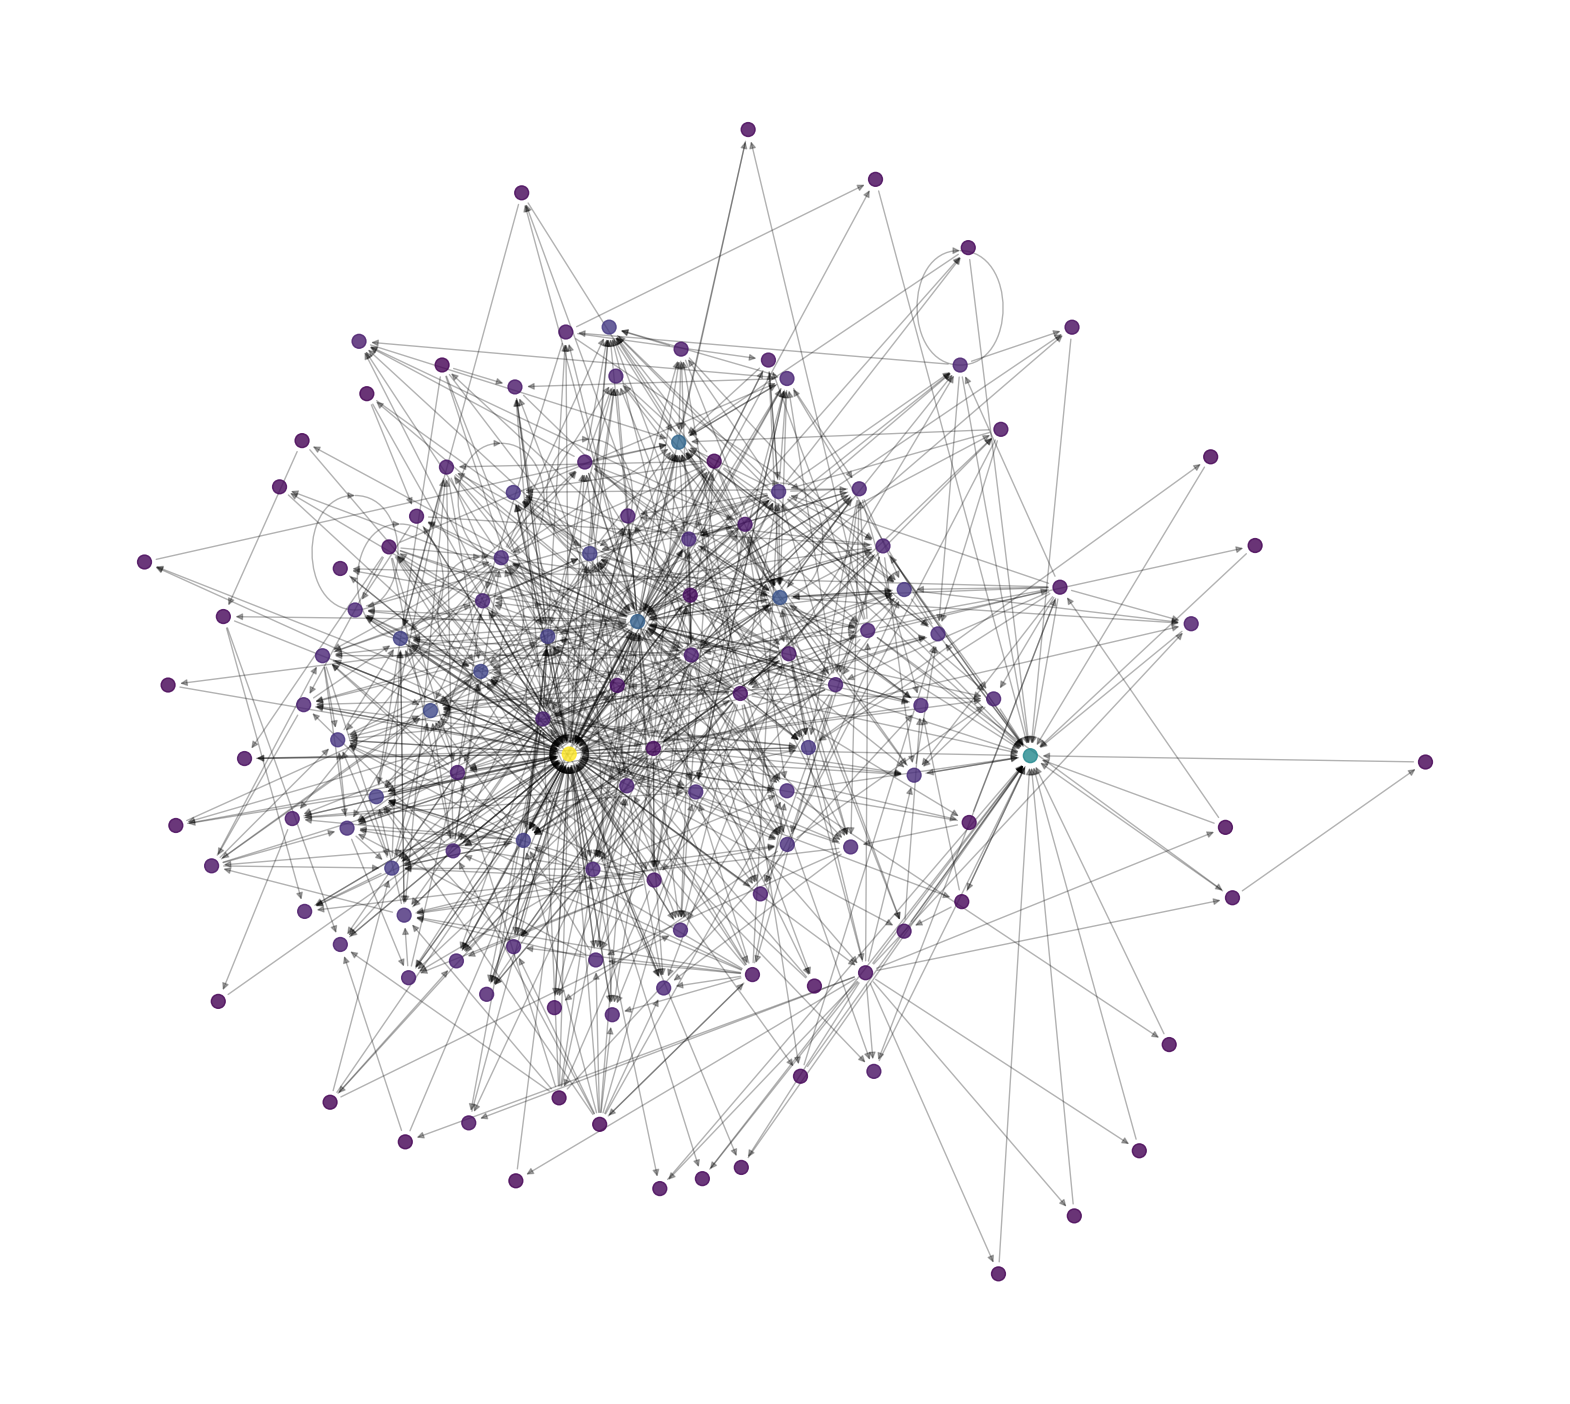

In [41]:
# Get strongly connected components
twitter_strongly_connected_components = list(nx.strongly_connected_components(twitter_G))
twitter_strongly_connected_components = sorted(twitter_strongly_connected_components, key=len, reverse=True)


# Draw the largest strongly connected component
draw_networkx_graph(twitter_G.subgraph(twitter_strongly_connected_components[0]), layout='kamada_kawai', size=(20,20), labels=False, override_node_size=100)

Build the retwork for "GOstats" combining 2 differents data source

In [42]:
from olivia_finder.data_source.repository_scrapers.cran import CranScraper
from olivia_finder.data_source.repository_scrapers.bioconductor import BioconductorScraper

bioconductor_pm_multiple = PackageManager(
    data_sources=[
        BioconductorScraper(),
        CranScraper(),
    ]
)
GOstats_G = bioconductor_pm_multiple.get_transitive_network_graph(
    package_name="GOstats",
    deep_level=3,
    generate=True
)
del bioconductor_pm_multiple
print(f'Nodes: {len(GOstats_G.nodes)}')
print(f'Edges: {len(GOstats_G.edges)}')

Nodes: 39
Edges: 131


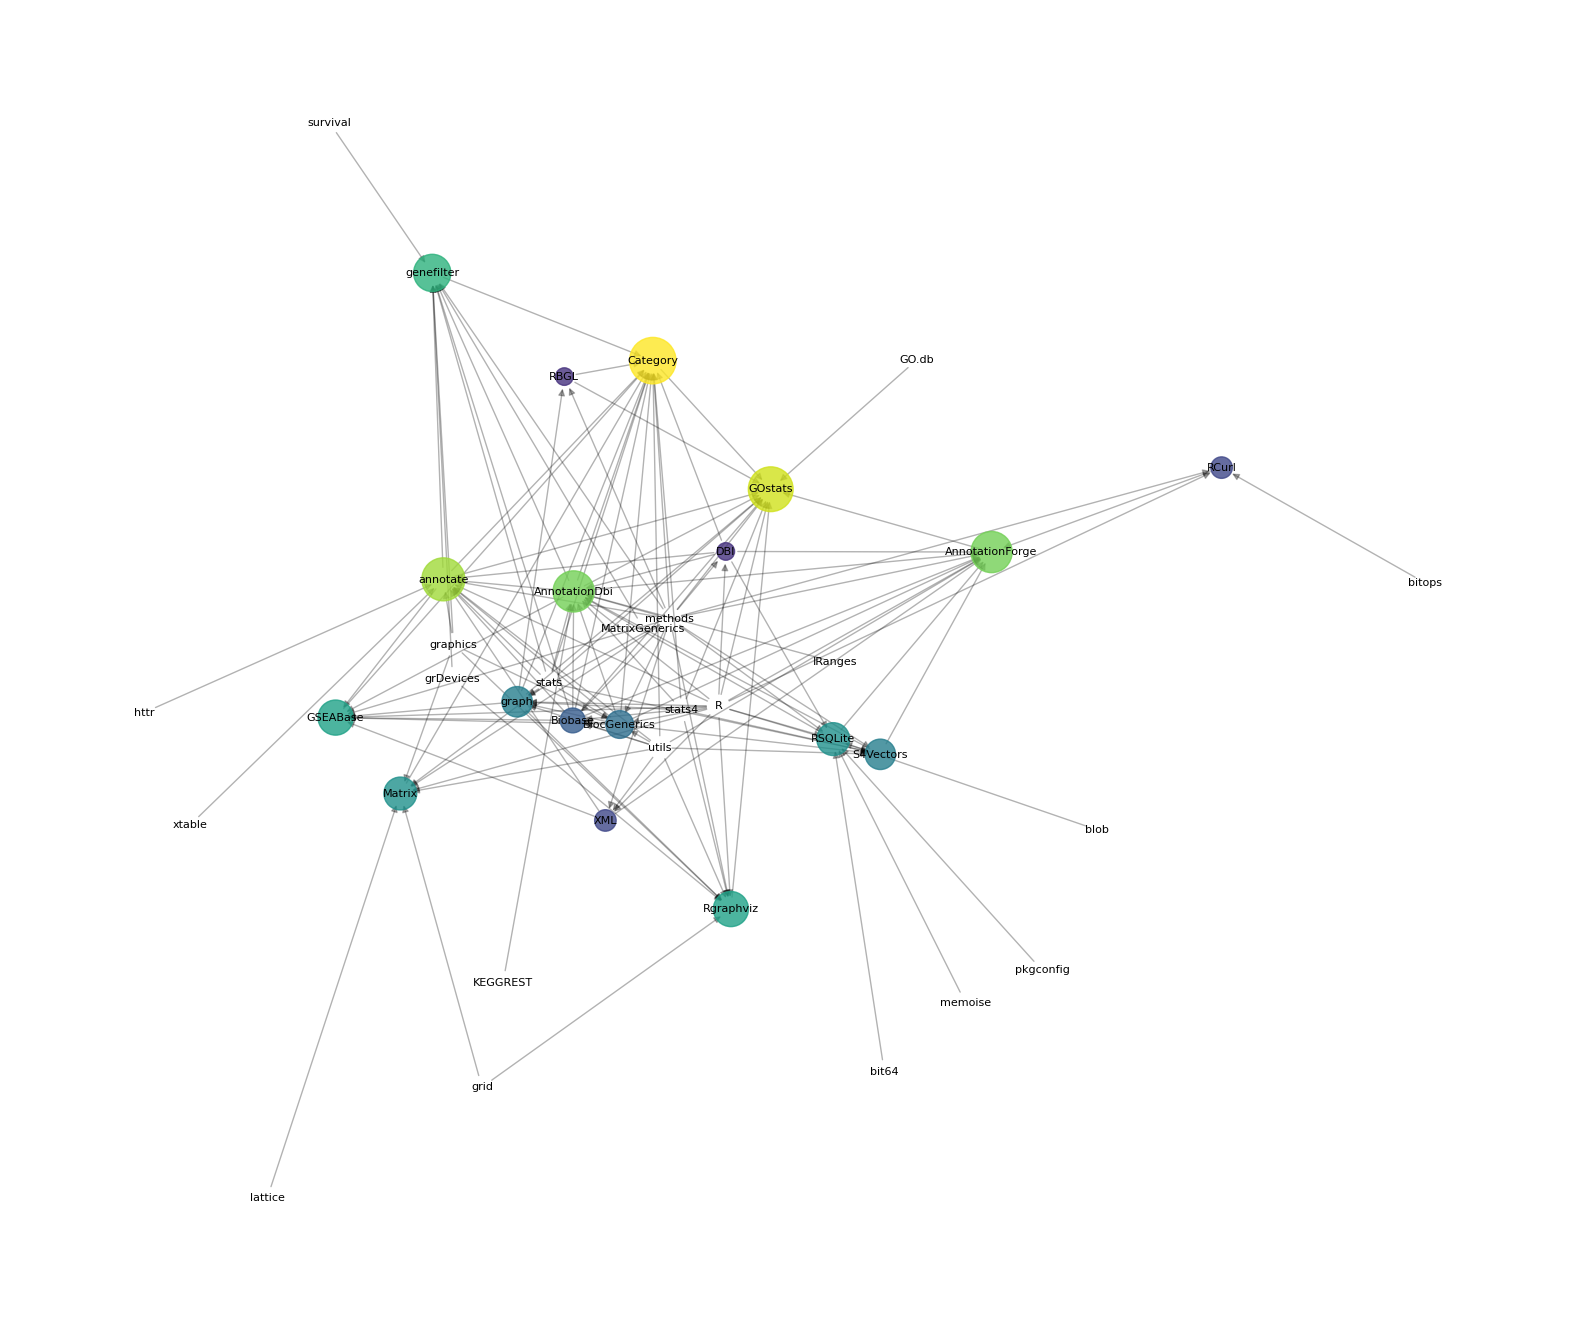

In [43]:
# Draw the graph
draw_networkx_graph(GOstats_G, layout='spring', size=(20,20), )

# **2 - Build olivia model**

In [44]:
from olivia.model import OliviaNetwork

### Using full network data from scraping

In [45]:
bioconductor_model = OliviaNetwork()
bioconductor_model.build_model(bioconductor_G_loaded)

Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done


### Using single package networks

In [46]:
twitter_network_model = OliviaNetwork()
twitter_network_model.build_model(twitter_G)

Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done


In [47]:
gostats_network_model = OliviaNetwork()
gostats_network_model.build_model(GOstats_G)

Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done


# **3 - Olivia metrics**

In [50]:
from olivia.networkmetrics import attack_vulnerability, failure_vulnerability

In [51]:
bioconductor_atack_vulnerability = attack_vulnerability(bioconductor_model)
bioconductor_failure_vulnerability = failure_vulnerability(bioconductor_model)

Computing Reach
     Processing node: 3K      
Reach retrieved from metrics cache


In [52]:
twitter_atack_vulnerability = attack_vulnerability(twitter_network_model)
twitter_failure_vulnerability = failure_vulnerability(twitter_network_model)

Computing Reach
     Processing node: 1K      
Reach retrieved from metrics cache


In [53]:
gostats_atack_vulnerability = attack_vulnerability(gostats_network_model)
gostats_failure_vulnerability = failure_vulnerability(gostats_network_model)

Computing Reach
     Processing node: 0K      
Reach retrieved from metrics cache


In [54]:
print(f'bioconductor_atack_vulnerability: {bioconductor_atack_vulnerability}')
print(f'bioconductor_failure_vulnerability: {bioconductor_failure_vulnerability}')
print()
print(f'twitter_atack_vulnerability: {twitter_atack_vulnerability}')
print(f'twitter_failure_vulnerability: {twitter_failure_vulnerability}')
print()
print(f'gostats_atack_vulnerability: {gostats_atack_vulnerability}')
print(f'gostats_failure_vulnerability: {gostats_failure_vulnerability}')

bioconductor_atack_vulnerability: 210
bioconductor_failure_vulnerability: 24.817326873753206

twitter_atack_vulnerability: 137
twitter_failure_vulnerability: 127.73367260390161

gostats_atack_vulnerability: 19
gostats_failure_vulnerability: 7.205128205128205
